In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
  
data_2 = pd.read_csv('./CSI_Preprocessing/output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns') 
data_2 = data_2.iloc[:,:-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])
  
date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,1970-01-01 00:00:01.641598541,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


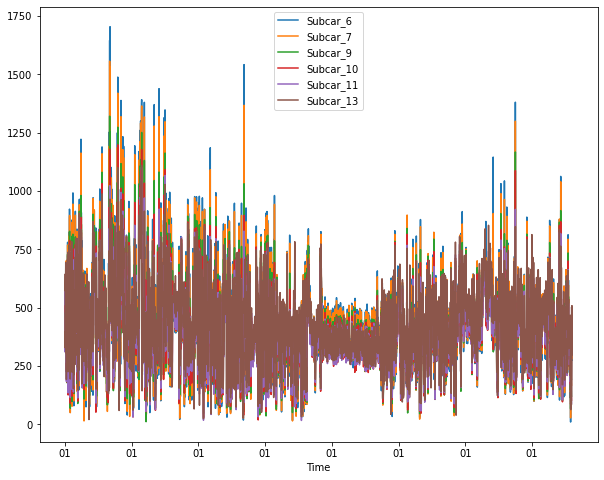

In [3]:
plot_cols = ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

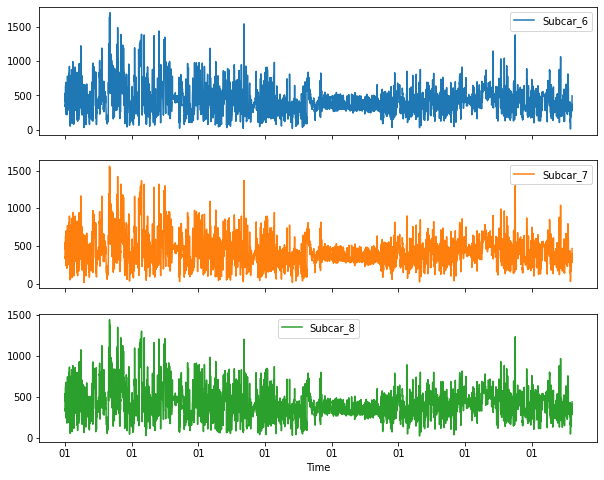

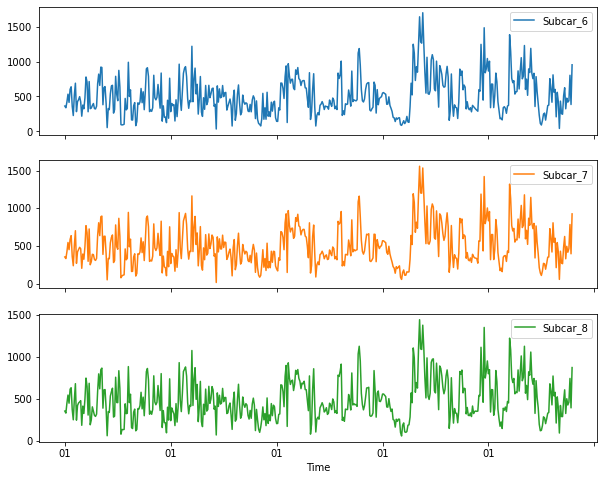

In [4]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [5]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())

          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158794  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360386   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [6]:
df_input = data_2[ ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']]
df_input.head()

,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
Time,,,,,,
1970-01-01 00:00:01.641598541,362.527240,353.411941,353.793725,347.315419,349.905702,396.717784
1970-01-01 00:00:01.641598542,338.013313,332.434956,319.820262,315.317301,310.386855,328.671569
1970-01-01 00:00:01.641598543,421.911128,424.001179,441.279956,441.367194,461.677377,500.372861
1970-01-01 00:00:01.641598544,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150
1970-01-01 00:00:01.641598545,415.226444,450.480854,458.423385,479.883319,511.391240,571.505031


In [7]:
df_input.describe()

,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
count,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,410.627681,403.013887,401.351757,432.789300
std,202.453002,193.543158,171.775869,160.406865,152.042491,151.963799
min,10.295630,14.764823,11.661904,19.235384,17.029386,21.023796
25%,295.032201,300.879956,301.906856,299.537560,302.426850,330.353976
50%,391.523942,393.309005,387.431284,381.450521,381.629371,416.394643
75%,511.462363,509.395703,496.494461,487.182967,486.122154,525.755407
max,1704.556541,1556.767484,1320.984860,1198.269586,1101.918781,1110.358951


In [8]:
df_input.query("Subcar_7 > 511")

,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
Time,,,,,,
1970-01-01 00:00:01.641598544,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150
1970-01-01 00:00:01.641598546,602.844093,587.749096,601.239553,597.501464,612.315278,648.398797
1970-01-01 00:00:01.641598546,639.425523,635.824661,631.708794,623.773196,629.221742,692.788568
1970-01-01 00:00:01.641598549,691.112871,701.485566,677.784627,655.331977,646.693900,689.844185
1970-01-01 00:00:01.641598556,780.515855,768.584413,730.010959,708.801806,698.401747,724.347983
...,...,...,...,...,...,...
1970-01-01 00:00:01.641600103,690.676480,678.564662,656.966514,620.133050,616.235345,648.617761
1970-01-01 00:00:01.641600104,521.008637,531.681296,533.258849,523.495941,529.429882,552.109591
1970-01-01 00:00:01.641600105,812.933577,793.832476,734.908158,700.594034,663.127439,660.100750


In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled

array([[0.20789691, 0.21961513, 0.26130438, 0.27826168, 0.30682973,
        0.34488374],
       [0.19342811, 0.2060114 , 0.23535703, 0.25112242, 0.27040311,
        0.28241792],
       [0.24294694, 0.26539277, 0.32812229, 0.35803186, 0.4098556 ,
        0.44003819],
       ...,
       [0.21040172, 0.2383719 , 0.31431976, 0.33538326, 0.37370201,
        0.44796594],
       [0.15600823, 0.17335685, 0.23619976, 0.27684802, 0.32360963,
        0.38368485],
       [0.28449823, 0.29206099, 0.30271959, 0.30005974, 0.3069601 ,
        0.25445416]])

In [10]:
features = data_scaled
target = data_scaled[:, 1]

In [11]:
TimeseriesGenerator(features, target, length=6, sampling_rate=1, batch_size=1)[1]

(array([[[0.19342811, 0.2060114 , 0.23535703, 0.25112242, 0.27040311,
          0.28241792],
         [0.24294694, 0.26539277, 0.32812229, 0.35803186, 0.4098556 ,
          0.44003819],
         [0.30872059, 0.34413675, 0.42085301, 0.44056306, 0.51928919,
          0.57273131],
         [0.23900145, 0.28256503, 0.34121565, 0.39069938, 0.4556795 ,
          0.50533689],
         [0.34973861, 0.37158449, 0.450292  , 0.49045743, 0.54870653,
          0.57592468],
         [0.37132999, 0.40276185, 0.47356299, 0.51273984, 0.56429011,
          0.6166741 ]]]),
 array([0.22401]))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=120, shuffle= False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)

X_train.shape:  (3041, 6)
X_test.shape:  (761, 6)


In [13]:
win_length = 144 # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 6 
train_generator =  tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator =  tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [14]:
train_generator[0]

(array([[[2.07896911e-01, 2.19615132e-01, 2.61304379e-01, 2.78261677e-01,
          3.06829726e-01, 3.44883745e-01],
         [1.93428108e-01, 2.06011404e-01, 2.35357027e-01, 2.51122415e-01,
          2.70403112e-01, 2.82417924e-01],
         [2.42946937e-01, 2.65392769e-01, 3.28122295e-01, 3.58031862e-01,
          4.09855597e-01, 4.40038185e-01],
         ...,
         [2.05591322e-01, 2.26909656e-01, 2.78355891e-01, 3.02533031e-01,
          3.39785596e-01, 3.81576669e-01],
         [2.22800783e-01, 2.46910161e-01, 3.17926143e-01, 3.67689429e-01,
          3.93654833e-01, 4.59108488e-01],
         [1.29300358e-02, 6.56585683e-05, 7.41774868e-02, 1.09615313e-01,
          1.46093732e-01, 2.28636131e-01]],
 
        [[1.93428108e-01, 2.06011404e-01, 2.35357027e-01, 2.51122415e-01,
          2.70403112e-01, 2.82417924e-01],
         [2.42946937e-01, 2.65392769e-01, 3.28122295e-01, 3.58031862e-01,
          4.09855597e-01, 4.40038185e-01],
         [3.08720588e-01, 3.44136749e-01, 4.208

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 128)          69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 144, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 144, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()] )

In [50]:
history = model.fit_generator(
    train_generator, epochs=50,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
    ])

Epoch 1/50
 5/91 [>.............................] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.1033

C:\Users\Owner\anaconda3\envs\Tensorflow2021\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


91/91 [==============================] - 3s 29ms/step - loss: 0.0146 - mean_absolute_error: 0.0894 - val_loss: 0.0100 - val_mean_absolute_error: 0.0774
Epoch 2/50
91/91 [==============================] - 3s 28ms/step - loss: 0.0144 - mean_absolute_error: 0.0890 - val_loss: 0.0099 - val_mean_absolute_error: 0.0770
Epoch 3/50
91/91 [==============================] - 3s 28ms/step - loss: 0.0144 - mean_absolute_error: 0.0885 - val_loss: 0.0096 - val_mean_absolute_error: 0.0755
Epoch 4/50
91/91 [==============================] - 3s 28ms/step - loss: 0.0138 - mean_absolute_error: 0.0866 - val_loss: 0.0096 - val_mean_absolute_error: 0.0755
Epoch 5/50
91/91 [==============================] - 3s 28ms/step - loss: 0.0134 - mean_absolute_error: 0.0853 - val_loss: 0.0093 - val_mean_absolute_error: 0.0742
Epoch 6/50
91/91 [==============================] - 3s 28ms/step - loss: 0.0133 - mean_absolute_error: 0.0848 - val_loss: 0.0092 - val_mean_absolute_error: 0.0734
Epoch 7/50
91/91 [===============

In [31]:
model.evaluate_generator(
    test_generator, verbose=0
)

C:\Users\Owner\anaconda3\envs\Tensorflow2021\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0101432204246521, 0.07817722111940384]

In [32]:
predictions = model.predict_generator(test_generator)

C:\Users\Owner\anaconda3\envs\Tensorflow2021\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [33]:
predictions.shape[0]

617

In [34]:
predictions

array([[0.3192576 ],
       [0.32033342],
       [0.32594755],
       [0.33357042],
       [0.34215492],
       [0.34587455],
       [0.34384093],
       [0.33949795],
       [0.33670864],
       [0.33535537],
       [0.3332725 ],
       [0.33226094],
       [0.3331602 ],
       [0.33139604],
       [0.32510114],
       [0.31693482],
       [0.30989352],
       [0.30712464],
       [0.30877262],
       [0.3104799 ],
       [0.31242606],
       [0.3126406 ],
       [0.31095096],
       [0.306434  ],
       [0.30093265],
       [0.3023083 ],
       [0.30193046],
       [0.2998722 ],
       [0.29643542],
       [0.29399067],
       [0.2925997 ],
       [0.29216295],
       [0.29251745],
       [0.29394525],
       [0.29614556],
       [0.29896867],
       [0.29982543],
       [0.2987149 ],
       [0.2980509 ],
       [0.29681587],
       [0.29630074],
       [0.29665756],
       [0.29747996],
       [0.2975794 ],
       [0.29737872],
       [0.29524708],
       [0.2956421 ],
       [0.300

In [35]:
y_test

array([0.24203571, 0.30083508, 0.31481666, 0.21677997, 0.22681627,
       0.22938731, 0.226963  , 0.22908969, 0.23646229, 0.12907813,
       0.16199401, 0.33715806, 0.17820557, 0.20220102, 0.330953  ,
       0.32251194, 0.24861634, 0.3697213 , 0.40798405, 0.25356629,
       0.24490763, 0.25600033, 0.25674673, 0.4013908 , 0.31805013,
       0.19378133, 0.27295387, 0.34716582, 0.18944059, 0.17567678,
       0.22488339, 0.16403723, 0.1973648 , 0.19375548, 0.22003038,
       0.21958302, 0.23736913, 0.23162255, 0.32145597, 0.3113312 ,
       0.24934099, 0.25115549, 0.19100665, 0.23795854, 0.33912952,
       0.30887039, 0.2976422 , 0.2033191 , 0.44509513, 0.09766221,
       0.3150914 , 0.20480734, 0.29767231, 0.30408799, 0.30091365,
       0.30650952, 0.30365125, 0.34438991, 0.32199674, 0.29031379,
       0.27984014, 0.265089  , 0.37766632, 0.3622374 , 0.20415013,
       0.4202522 , 0.21799276, 0.35244362, 0.25075516, 0.25088356,
       0.25372207, 0.19759229, 0.28046069, 0.28330046, 0.27456

In [36]:
x_test

array([[0.2168591 , 0.24203571, 0.29244596, 0.3134606 , 0.34584301,
        0.37194661],
       [0.27466951, 0.30083508, 0.35198348, 0.37667641, 0.4106156 ,
        0.4547261 ],
       [0.27995243, 0.31481666, 0.36175921, 0.38586061, 0.4290162 ,
        0.46590012],
       ...,
       [0.21040172, 0.2383719 , 0.31431976, 0.33538326, 0.37370201,
        0.44796594],
       [0.15600823, 0.17335685, 0.23619976, 0.27684802, 0.32360963,
        0.38368485],
       [0.28449823, 0.29206099, 0.30271959, 0.30005974, 0.3069601 ,
        0.25445416]])

In [37]:
x_test[:,1:][win_length:]

array([[0.39290612, 0.46520267, 0.49814461, 0.55270415, 0.59557968],
       [0.42747553, 0.52068892, 0.60819308, 0.62967567, 0.69314958],
       [0.42183486, 0.4937544 , 0.5346585 , 0.59670373, 0.64574991],
       ...,
       [0.2383719 , 0.31431976, 0.33538326, 0.37370201, 0.44796594],
       [0.17335685, 0.23619976, 0.27684802, 0.32360963, 0.38368485],
       [0.29206099, 0.30271959, 0.30005974, 0.3069601 , 0.25445416]])

In [38]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
df_pred

,0,0,1,2,3,4
0,0.319258,0.392906,0.465203,0.498145,0.552704,0.595580
1,0.320333,0.427476,0.520689,0.608193,0.629676,0.693150
2,0.325948,0.421835,0.493754,0.534658,0.596704,0.645750
3,0.333570,0.443589,0.516005,0.564733,0.613395,0.674740
4,0.342155,0.338828,0.391878,0.416187,0.471090,0.508363
...,...,...,...,...,...,...
612,0.206048,0.246812,0.314976,0.343359,0.369597,0.439903
613,0.218598,0.237556,0.300301,0.333923,0.388717,0.428067
614,0.234170,0.238372,0.314320,0.335383,0.373702,0.447966
615,0.249673,0.173357,0.236200,0.276848,0.323610,0.383685


In [39]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred)
rev_trans

array([[551.20128048, 620.62710221, 620.76243443, 606.56491821,
        616.65225208, 669.80967446],
       [553.02402404, 673.93323111, 693.41185453, 736.31582898,
        700.15783935, 776.09599922],
       [562.5358279 , 665.23529672, 658.14588049, 649.61604044,
        664.38693545, 724.46186925],
       ...,
       [407.04104375, 382.3349317 , 423.20798669, 414.66371917,
        422.4547313 , 509.00884079],
       [433.30700102, 282.08154849, 320.92366694, 345.64866556,
        368.1100379 , 438.98519337],
       [452.60776434, 465.12363948, 408.01960737, 373.01608544,
        350.04713968, 298.20965779]])

In [40]:
df_final = df_input[predictions.shape[0]*-1:]

In [41]:
df_final.count()

Subcar_6     617
Subcar_7     617
Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_13    617
dtype: int64

In [42]:
df_final['Subcar_7_pred'] = rev_trans[:, 1]
df_final

C:\Users\Owner\anaconda3\envs\Tensorflow2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_7_pred
Time,,,,,,,
1970-01-01 00:00:01.641599861,603.491508,620.627102,620.762434,606.564918,616.652252,669.809674,620.627102
1970-01-01 00:00:01.641599861,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,673.933231
1970-01-01 00:00:01.641599861,656.558451,665.235297,658.145880,649.616040,664.386935,724.461869,665.235297
1970-01-01 00:00:01.641599861,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,698.779651
1970-01-01 00:00:01.641599861,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,537.239239
...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600114,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,395.349213
1970-01-01 00:00:01.641600114,362.663756,381.077420,404.853060,412.941885,438.744801,487.332535,381.077420
1970-01-01 00:00:01.641600114,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,382.334932


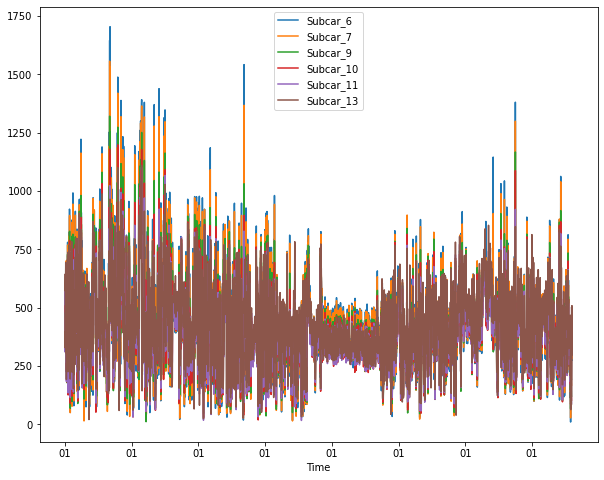

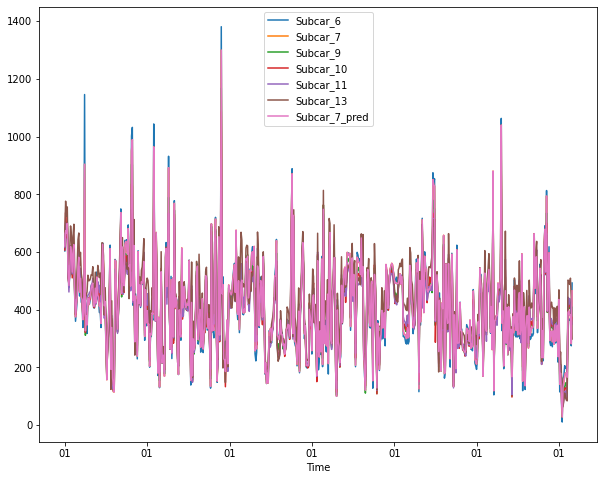

In [43]:
plot_cols = ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = df_input[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

df_final[['Subcar_7', 'Subcar_7_pred']]
df_final.index = date_time[:617]
_ = df_final.plot(subplots=False)

In [59]:
# Let's define a EDA function for repeated calls on individual time series:

import statsmodels.api as sm  # seasonal trend decomposition
from statsmodels.graphics import tsaplots   # autocorrelation

def eda(df_name, ts_name, decomp_model='additive'):
    """ 
    Inputs: df_name - name of the dataframe
            ts_name - name of the time series in the dataframe
            decomp_model - 'additive'/'multiplicative'
    Outputs: EDA statistics and plots for individual time series in df_name
    """
    # Statistics
    print(f'Statistic of {ts_name} time series')
    print(df_name[ts_name].describe())
    
    # Plotting
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24,24))
    fig.suptitle(f'Visualization of the "{ts_name}" time series', fontsize=24)
        
    # Observed values of the time series against target_class values
    df_name[ts_name].plot(ylim=[df_name[ts_name].min(), df_name[ts_name].max()],
                          linewidth=2, ax=axs[0,0])
    axs[0,0].set_title('Observed values (red/green where target_class=0/1)')
    axs[0,0].set_xlabel('')
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==0),
                          facecolor='red', alpha=0.5)
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==1),
                          facecolor='green', alpha=0.5)
    axs[0,0].axvline('2017-01-01', color='red', linestyle='dashed')
    
    # Seasonality, trend and noise in time series data
    decomp = sm.tsa.seasonal_decompose(df_name[ts_name],
                                       model=decomp_model)
    decomp.trend.plot(linewidth=2, ax=axs[0,1])
    axs[0,1].set_title('Trend values')
    axs[0,1].set_xlabel('')
    decomp.seasonal.plot(linewidth=2, ax=axs[1,0])
    axs[1,0].set_title('Seasonal values')
    axs[1,0].set_xlabel('')
    decomp.resid.plot(linewidth=2, ax=axs[1,1])
    axs[1,1].set_title('Residual values')
    axs[1,1].set_xlabel('')
    
    # Distribution of values of time series
    df_name[ts_name].plot.hist(bins=30, ax=axs[2,0])
    axs[2, 0].set_title('Histogram')
    df_name[[ts_name]].boxplot(ax=axs[2,1])
    axs[2, 1].set_title('Boxplot')
        
    # Autocorrelation of time series
    tsaplots.plot_acf(df_name[ts_name], lags=40, ax=axs[3,0])
    tsaplots.plot_pacf(df_name[ts_name], lags=40, ax=axs[3,1])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()